In [1]:
from nerfstudio.pipelines.imaginedriving_pipeline import ImagineDrivingPipelineConfig, ImagineDrivingPipeline
from nerfstudio.data.datamanagers.ad_datamanager import ADDataManagerConfig, ADDataManager
from nerfstudio.data.dataparsers.pandaset_dataparser import PandaSetDataParserConfig

from nerfstudio.cameras.camera_optimizers import CameraOptimizerConfig
from nerfstudio.models.neurad import NeuRADModelConfig

In [2]:
%load_ext autoreload
%autoreload 2
%cd ~/dev/neurad-studio

/home/gasparyanartur/dev/neurad-studio


In [5]:
from dataclasses import asdict

config = ImagineDrivingPipelineConfig(
    datamanager=ADDataManagerConfig(
        dataparser=PandaSetDataParserConfig(
            add_missing_points=True,
            dataset_end_fraction=0.2,
            cameras=("front", "front_left")
        ),
        num_processes=0,
    ),
    model=NeuRADModelConfig(
        eval_num_rays_per_chunk=1 << 15,
        camera_optimizer=CameraOptimizerConfig(mode="off"),  # SO3xR3
    ),
)
asdict(config)

{'_target': nerfstudio.pipelines.imaginedriving_pipeline.ImagineDrivingPipeline,
 'datamanager': {'_target': nerfstudio.data.datamanagers.ad_datamanager.ADDataManager,
  'data': None,
  'masks_on_gpu': False,
  'images_on_gpu': False,
  'dataparser': {'_target': nerfstudio.data.dataparsers.pandaset_dataparser.PandaSet,
   'data': PosixPath('data/pandaset'),
   'sequence': '001',
   'train_split_fraction': 0.5,
   'train_eval_split_type': <SplitTypes.LINSPACE: 'linspace'>,
   'max_eval_frames': None,
   'dataset_start_fraction': 0.0,
   'dataset_end_fraction': 0.2,
   'cameras': ('front', 'front_left'),
   'lidars': ('Pandar64',),
   'min_lidar_dist': (1.0, 2.0, 2.0),
   'radars': (),
   'load_cuboids': True,
   'include_deformable_actors': False,
   'annotation_interval': 0.1,
   'rolling_shutter_offsets': (-0.03, 0.01),
   'allow_per_point_times': True,
   'add_missing_points': True,
   'lidar_elevation_mapping': {'Pandar64': {0: 14.882,
     1: 11.032,
     2: 8.059,
     3: 5.057,
 

In [38]:
pipe = ImagineDrivingPipeline(config, device='cuda')

Output()

Output()

Setting up evaluation dataset...

Caching all 16 images.

Output()

Caching all 8 images.

Output()

4D hashgrid is not supported with torch implementation, falling back multiple grids.

4D hashgrid is not supported with torch implementation, falling back multiple grids.

4D hashgrid is not supported with torch implementation, falling back multiple grids.

/home/gasparyanartur/dev/neurad-studio/venv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/gasparyanartur/dev/neurad-studio/venv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/home/gasparyanartur/dev/neurad-studio/venv/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

In [8]:
pipe.datamanager

ADDataManager(
  (train_lidar_ray_generator): LidarRayGenerator()
  (eval_ray_generator): RayGenerator()
  (eval_lidar_ray_generator): LidarRayGenerator()
)

In [165]:
import matplotlib.pyplot as plt
from copy import deepcopy

import torch
import torchvision.transforms as tvtf

from nerfstudio.models.diffusion import load_diffusion_model, DiffusionModel, ModelId
from nerfstudio.cameras.cameras import Cameras
from nerfstudio.pipelines.imaginedriving_pipeline import augment_ray_bundle, rotate_around

torch.Size([512, 512, 3])


/home/gasparyanartur/dev/neurad-studio/venv/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


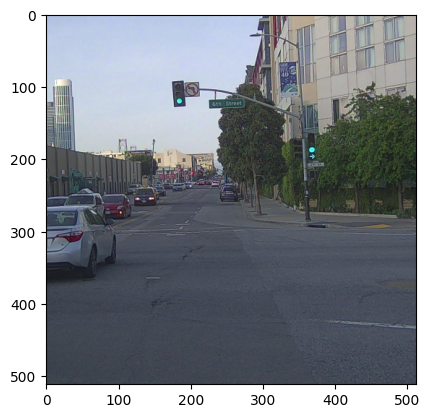

In [39]:
img_transform = tvtf.Compose((tvtf.ConvertImageDtype(torch.float32), tvtf.CenterCrop((1024, 1024)), tvtf.Resize((512, 512))))

ex_img = pipe.datamanager.train_dataset.get_image_float32(0).permute(2, 0, 1)
ex_img = img_transform(ex_img).permute(1, 2, 0)

print(ex_img.shape)
plt.imshow(ex_img)

In [40]:
sd_pipe = load_diffusion_model({"model_name": "sd_base", "model_id": ModelId.sd_v2_1, "low_mem_mode": True})
#pipe = load_diffusion_model({"model_name": "mock"})

/home/gasparyanartur/dev/neurad-studio/venv/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

torch.Size([512, 512, 3])
torch.Size([1, 512, 512, 3])


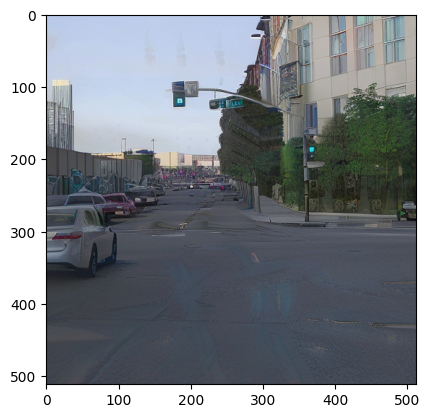

In [46]:
print(ex_img.shape)
ex_out = sd_pipe.get_diffusion_output({"rgb": ex_img})
print(ex_out["rgb"].shape)
plt.imshow(ex_out["rgb"][0].cpu().float())

In [83]:
ray_bundle, batch = pipe.datamanager.next_train(0)
cameras = pipe.datamanager.train_dataset.cameras

In [84]:
is_cam = ~ray_bundle.metadata["is_lidar"].flatten()
orig = ray_bundle.origins[is_cam].cpu()
dirs = ray_bundle.directions[is_cam].cpu()
cam_to_worlds = cameras.camera_to_worlds[ray_bundle.camera_indices[is_cam].cpu()]

In [88]:
print(orig.mean(dim=0), orig.std(dim=0))
print(dirs.mean(dim=0), dirs.std(dim=0))

tensor([-0.3255,  4.5555, -0.1719]) tensor([0.3332, 2.4631, 0.1399])
tensor([-0.3128,  0.7263, -0.0835]) tensor([0.5431, 0.2424, 0.1182])


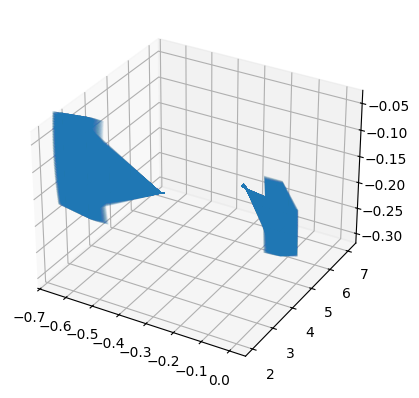

In [89]:
fig = plt.figure()
fig.add_subplot(projection='3d')
ax = fig.gca()
ax.quiver(
    orig[:, 0],
    orig[:, 1],
    orig[:, 2],
    dirs[:, 0],
    dirs[:, 1],
    dirs[:, 2],
    length=0.5,
    linewidths=0.01,
)

plt.show()

In [81]:
# 90 degree shift should reflect on image


In [158]:


 
def make_cam_matrix(rotation, translation):
    return torch.cat((rotation, translation[..., None]), dim=-1)[None, ...]

In [159]:
v = torch.tensor([1, 0, 0]).float().T

print(rotate_around(torch.pi/2, 0) @ v, rotate_around(torch.pi/2, 1) @ v, rotate_around(torch.pi/2, 2) @ v)
print(rotate_around(torch.pi/2, 0) @ rotate_around(torch.pi/2, 1) @ rotate_around(torch.pi/2, 2) @ v)
print(rotate_around(torch.pi/2, 2) @ rotate_around(torch.pi/2, 1) @ rotate_around(torch.pi/2, 0) @ v)

tensor([1., 0., 0.]) tensor([-4.3711e-08,  0.0000e+00, -1.0000e+00]) tensor([-4.3711e-08,  1.0000e+00,  0.0000e+00])
tensor([ 1.9107e-15, -8.7423e-08,  1.0000e+00])
tensor([ 1.9107e-15, -4.3711e-08, -1.0000e+00])


In [160]:
v1 = torch.tensor([1, 0, 0, 0]).float().T
vs = []
n_vs = 8
for i in range(n_vs):
    theta = 2 * i * torch.pi / n_vs 
    flip_cam = make_cam_matrix(rotate_around(theta, 2), torch.zeros(3))
    v = (flip_cam @ v1).flatten()
    vs.append(v)

dirs = torch.stack(vs)
origs = torch.zeros_like(dirs)

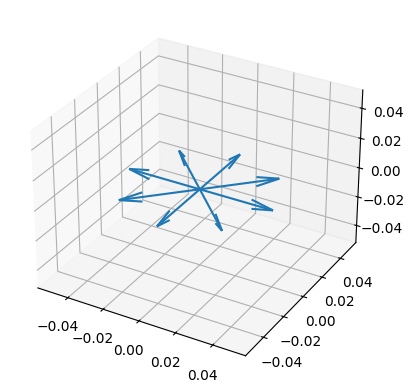

In [161]:
fig = plt.figure()
fig.add_subplot(projection='3d')
ax = fig.gca()

ax.quiver(
    origs[:, 0],
    origs[:, 1],
    origs[:, 2],
    dirs[:, 0], 
    dirs[:, 1],
    dirs[:, 2],
    normalize=False,
    length=0.04,
)

In [166]:


new_c2ws = []
for i in range(6):
    new_c2ws.append(torch.hstack((rotate_around(2 * i * torch.pi / n_vs , 2), torch.zeros(3, 1))))
new_c2ws = torch.stack(new_c2ws)

cams = Cameras(new_c2ws, 0., 0., 0., 0.)

print(cameras.shape, cams.shape)
print(cameras.camera_to_worlds.shape, cams.camera_to_worlds.shape)

torch.Size([16]) torch.Size([6])
torch.Size([16, 3, 4]) torch.Size([6, 3, 4])


In [167]:
cams.camera_to_worlds

tensor([[[ 1.0000e+00, -0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00]],

        [[ 7.0711e-01, -7.0711e-01,  0.0000e+00,  0.0000e+00],
         [ 7.0711e-01,  7.0711e-01,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00]],

        [[-4.3711e-08, -1.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 1.0000e+00, -4.3711e-08,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00]],

        [[-7.0711e-01, -7.0711e-01,  0.0000e+00,  0.0000e+00],
         [ 7.0711e-01, -7.0711e-01,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00]],

        [[-1.0000e+00,  8.7423e-08,  0.0000e+00,  0.0000e+00],
         [-8.7423e-08, -1.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00]],

        [[-7.0711e-01,  7.0711e-01,  0.0000e+

In [168]:


ray_bundle_2 = deepcopy(ray_bundle)
ray_bundle_2.origins = torch.zeros(8, 3)
ray_bundle_2.directions = torch.Tensor([[1, 0, 0]]).repeat(8, 1)
ray_bundle_2.metadata["is_lidar"] = torch.Tensor([False, False, False, False, False, False, True, True])[..., None].bool()
ray_bundle_2.camera_indices = torch.arange(8).long()[..., None]

ray_bundle_2

RayBundle(origins=tensor([[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]]), directions=tensor([[1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.]]), pixel_area=tensor([[2.4792e-07],
        [2.4774e-07],
        [2.4758e-07],
        ...,
        [4.5000e-06],
        [4.5000e-06],
        [4.5000e-06]], device='cuda:0'), camera_indices=tensor([[0],
        [1],
        [2],
        [3],
        [4],
        [5],
        [6],
        [7]]), nears=None, fars=tensor([[1000000.],
        [1000000.],
        [1000000.],
        ...,
        [1000000.],
        [1000000.],
        [1000000.]], device='cuda:0'), metadata={'sensor_idxs': tensor([[0],
        [0],
        [0],
        ...,
        [2],
        [2],
        [2]], device='cuda:0', dtype=torch.int3

In [171]:
augment_ray_bundle(ray_bundle_2, torch.FloatTensor((1, 0, 0, 0, 0, 0)), cams)

RayBundle(origins=tensor([[ 1.0000e+00,  0.0000e+00,  0.0000e+00],
        [ 7.0711e-01,  7.0711e-01,  0.0000e+00],
        [-4.3711e-08,  1.0000e+00,  0.0000e+00],
        [-7.0711e-01,  7.0711e-01,  0.0000e+00],
        [-1.0000e+00, -8.7423e-08,  0.0000e+00],
        [-7.0711e-01, -7.0711e-01,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00]]), directions=tensor([[1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.]]), pixel_area=tensor([[2.4792e-07],
        [2.4774e-07],
        [2.4758e-07],
        ...,
        [4.5000e-06],
        [4.5000e-06],
        [4.5000e-06]], device='cuda:0'), camera_indices=tensor([[0],
        [1],
        [2],
        [3],
        [4],
        [5],
        [6],
        [7]]), nears=None, fars=tensor([[1000000.],
        [1000000.],
        [1000000.],
        ...,
        [1000

In [173]:
augment_ray_bundle(ray_bundle_2, torch.FloatTensor((0, 0, 0, 0, 0, torch.pi/2)), cams)

RayBundle(origins=tensor([[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]]), directions=tensor([[ 1.9107e-15, -4.3711e-08, -1.0000e+00],
        [ 1.9107e-15, -4.3711e-08, -1.0000e+00],
        [ 1.9107e-15, -4.3711e-08, -1.0000e+00],
        [ 1.9107e-15, -4.3711e-08, -1.0000e+00],
        [ 1.9107e-15, -4.3711e-08, -1.0000e+00],
        [ 1.9107e-15, -4.3711e-08, -1.0000e+00],
        [ 1.0000e+00,  0.0000e+00,  0.0000e+00],
        [ 1.0000e+00,  0.0000e+00,  0.0000e+00]]), pixel_area=tensor([[2.4792e-07],
        [2.4774e-07],
        [2.4758e-07],
        ...,
        [4.5000e-06],
        [4.5000e-06],
        [4.5000e-06]], device='cuda:0'), camera_indices=tensor([[0],
        [1],
        [2],
        [3],
        [4],
        [5],
        [6],
        [7]]), nears=None, fars=tensor([[1000000.],
        [1000000.],
        [1000000.],
        ...,
        [1000